In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
#from torchvision.transforms import transforms

from lib.cfg import *
from lib.dataloader import get_calcification_data_index, DatasetThyroid
from lib.model import Unet

In [2]:
# U-Net init
unet = Unet(3, 1).cuda()
unet.load_state_dict(torch.load('./unet_calcification_epoch30.pth'))

<All keys matched successfully>

# Visualization

In [ ]:
# Calcification mask prediction (requires full dataset)
df_data_index = get_calcification_data_index()
dataloader_test = DataLoader(
    DatasetThyroid(df_data_index, image_transform, mask_transform, False), 
    batch_size=1,
    shuffle=True,
    num_workers=1
)

batch = next(iter(dataloader_test))
i = 0
pid = batch[3]
pid_str = str(int(pid[i].numpy()))
img_raw = plt.imread('./thyroid_data/CEUS1012_ex_sight/P_TT-' + pid_str + '.png')

mask_gt = batch[1]
mask_gt = mask_gt[0][0]

img = batch[0].cuda()
mask_pred = unet(img)
mask_pred_proba = mask_pred[i].detach().cpu().numpy()[0]
mask_pred_threshold = mask_pred_proba > 0

In [3]:
# Calcification mask prediction (for example_data)
image_path = './example_data/P_TT-2271.png'
mask_path = './example_data/P_TT-2271_mask_calcification.png'

img_raw = plt.imread(image_path)
mask_gt = plt.imread(mask_path)

img = Image.open(image_path).resize(IMAGE_RESIZE_DIM)
img = image_transform(img)
img = img.unsqueeze(0).cuda()

mask_pred = unet(img)
mask_pred_proba = mask_pred[0].detach().cpu().numpy()[0]
mask_pred_threshold = mask_pred_proba > 0

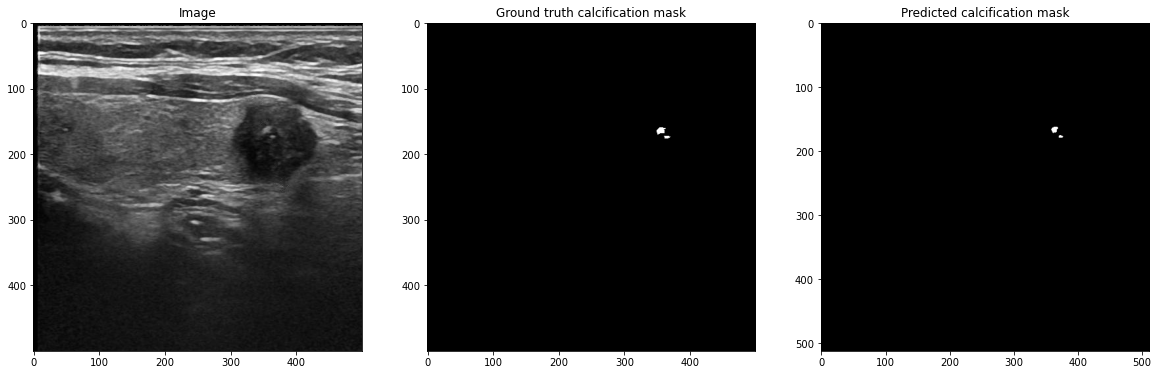

In [4]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(131)
ax.set_title('Image')
plt.imshow(img_raw)

ax = fig.add_subplot(132)
ax.set_title('Ground truth calcification mask')
plt.imshow(mask_gt, cmap='gray')

ax = fig.add_subplot(133)
ax.set_title('Predicted calcification mask')
plt.imshow(mask_pred_threshold, cmap='gray')

plt.show()